# D(St)reams of Anomalies

## Anomaly Detection

#### Submitted By: Arman Ghasemi KU ID: 2970754 Email:arman.ghasemi@ku.edu

In this project one of the datasets from realAWSCloudwatch has been selected. Three methods of anomaly detection, Interquartile Range (IQR), Isolation Forest and One Class Support Vector Machine, has been applied.

#### Data source: https://www.kaggle.com/boltzmannbrain/nab

First of all useful library should be imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.stats import iqr
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

Reading dataset from the url and showing 10 first rows of the dataset.

In [2]:
DF = pd.read_csv('https://raw.githubusercontent.com/armangh67/Anomaly-Detection/master/datasets/ec2_cpu_utilization_53ea38.csv', low_memory = False)
DF.head(10)

,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706
5,2014-02-14 14:55:00,1.734
6,2014-02-14 15:00:00,1.766
7,2014-02-14 15:05:00,1.766
8,2014-02-14 15:10:00,2.026
9,2014-02-14 15:15:00,1.762


To understand the dataset, the info has been shown as below.

In [3]:
print(DF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
timestamp    4032 non-null object
value        4032 non-null float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
None


## Feature Engineering

First of all data visualization can be a good point to start. Something like seeing the range of the dataset and ploting the dataset. For ploting timestamp column should be changed to datetime.

In [4]:
DF['timestamp'].min(), DF['timestamp'].max() #range of the data

('2014-02-14 14:30:00', '2014-02-28 14:25:00')

In [5]:
DF['timestamp'] = pd.to_datetime(DF['timestamp']) # change the type of timestamp column

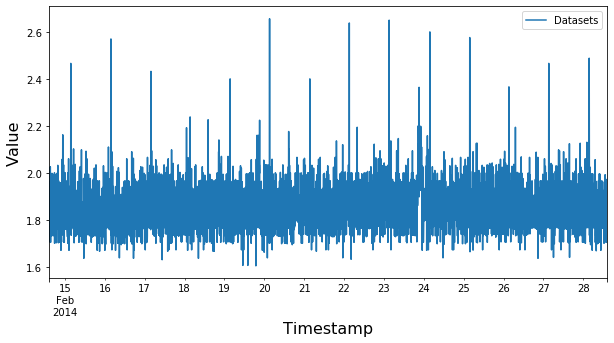

In [6]:
DF.plot(x='timestamp', y='value', figsize=(10,5),label='Datasets')
plt.xlabel('Timestamp', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend()


All the dates can be divided to different category such as weekday and weekend. Also timestamp can be converted to time epoch which is easier for the data ploting.

In [7]:
DF['Days'] = DF['timestamp'].dt.dayofweek
DF['Weekday'] = (DF['Days'] < 5).astype(int)
DF['time_epoch'] = (DF['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
DF.head(10)

,timestamp,value,Days,Weekday,time_epoch
0,2014-02-14 14:30:00,1.732,4,1,13923882
1,2014-02-14 14:35:00,1.732,4,1,13923885
2,2014-02-14 14:40:00,1.960,4,1,13923888
3,2014-02-14 14:45:00,1.732,4,1,13923891
4,2014-02-14 14:50:00,1.706,4,1,13923894
5,2014-02-14 14:55:00,1.734,4,1,13923897
6,2014-02-14 15:00:00,1.766,4,1,13923900
7,2014-02-14 15:05:00,1.766,4,1,13923903
8,2014-02-14 15:10:00,2.026,4,1,13923906
9,2014-02-14 15:15:00,1.762,4,1,13923909


For example here for Monday to Friday the 'Days' Column will be 0 to 4 respectively and the 'Weekday' flag will be 1, also for Saturday and Sunday it will be 0.

## Interquartile Range (IQR)

The IQR is a measure of variability, based on dividing a data set into quartiles. Quartiles divide a rank-ordered data set into four equal parts. The values that separate parts are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively

In [8]:
def Interquartile_Range(DF):
    sorted(DF['value'])
    Q1, Q3= np.percentile(DF['value'],[25,75])
    IQR = iqr(DF['value'])
    band_low = Q1 -(1.5 * IQR) 
    band_up = Q3 +(1.5 * IQR)    
    n = 0
    for row in DF.iterrows():
        if row[1]['value'] > band_up or row[1]['value'] < band_low:
            n = n + 1            
    print("Number of Anomalies is", n)
Interquartile_Range(DF)

Number of Anomalies is 211


The number of anomalies which is derived from the IQR method is 211. It is basic math an statistics and easy to implement but it has limited accuracy.

## Isolation Forest

In [9]:
DF_iso = DF.loc[:,['value' , 'Days', 'Weekday']]
min_max_scaler = preprocessing.StandardScaler()
DF_normalized = min_max_scaler.fit_transform(DF_iso) #How to normalize the Train and Test data using MinMaxScaler sklearn
DF_iso = pd.DataFrame(DF_normalized) 
model =  IsolationForest(n_estimators=1000, contamination = 0.05)
model.fit(DF_iso)
DF['anomaly_IF'] = pd.Series(model.predict(DF_iso))
DF['anomaly_IF'] = DF['anomaly_IF'].map( {1: 0, -1: 1} )
print("Normal, Anomalies\n",DF['anomaly_IF'].value_counts().values)

C:\Users\a454g185\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\a454g185\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Normal, Anomalies
 [3831  201]


The number of anomalies which are driven from Isolation Forest method is 201.

For visualing the datasets the figure below has been plotted.

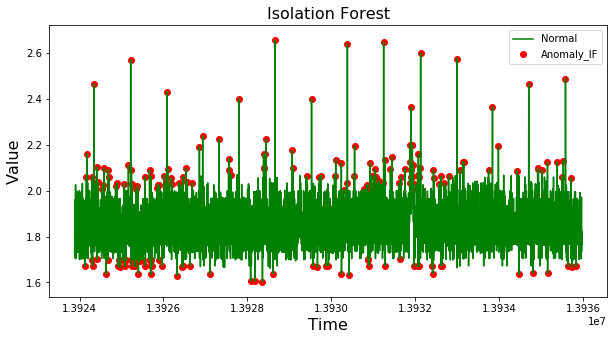

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

a = DF.loc[DF['anomaly_IF'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(DF['time_epoch'], DF['value'], color='green', label='Normal')
ax.scatter(a['time_epoch'],a['value'], color='red', label='Anomaly_IF')
plt.title('Isolation Forest', fontsize = 16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend()
plt.show()

## One Class Support Vector Machine

In [11]:
DF_svm = DF.loc[:,['value' , 'Days', 'Weekday']]
DFsvm_normalize = min_max_scaler.fit_transform(DF_svm)
model =  OneClassSVM(nu=0.05)
DF_svm = pd.DataFrame(DFsvm_normalize)
model.fit(DF_svm)
DF['anomaly_svm'] = pd.Series(model.predict(DF_svm))
DF['anomaly_svm'] = DF['anomaly_svm'].map( {1: 0, -1: 1} )
print("Normal, Anomalies\n", DF['anomaly_svm'].value_counts().values)

Normal, Anomalies
 [3811  221]


The number of anomalies which are driven from SVM method is 221.

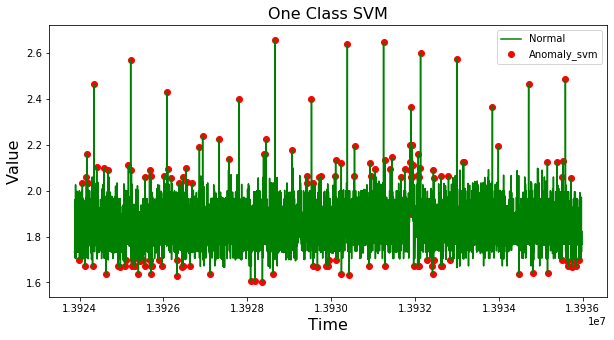

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

a = DF.loc[DF['anomaly_svm'] == 1, ['time_epoch', 'value']]

ax.plot(DF['time_epoch'], DF['value'], color='green', label='Normal')
ax.scatter(a['time_epoch'],a['value'], color='red', label='Anomaly_svm')
plt.title('One Class SVM', fontsize = 16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend()
plt.show()

## Conclusion

Three methods of anomaly detection has been implemented and the results are listed as below.

1- Interquartile Range (IQR): 211 anomalies detected out of 4032 records

2- Isolation Forest: 201 anomalies detected out of 4032 records

3- One Class Support Vector Machine: 221 anomalies detected out of 4032 records